In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from scipy.stats import wasserstein_distance

import os
import gc
gc.enable()

In [2]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

This notebook use Weighted Average Ensemble for Transfer Learning to predict based on finetuned models

## Load and scale data

In [4]:
def scale(x):
    scaler = MinMaxScaler(feature_range=(-1,1))
    x = scaler.fit_transform(x)
    
    return x

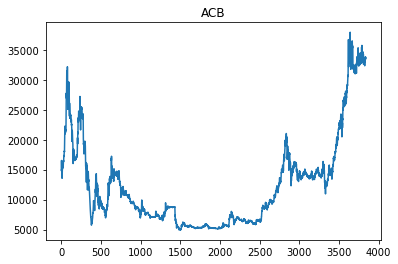

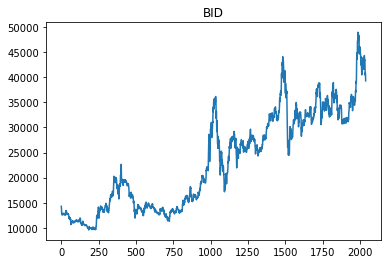

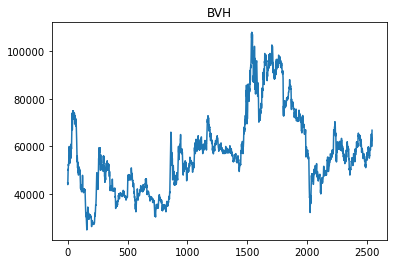

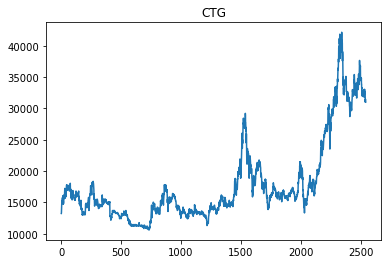

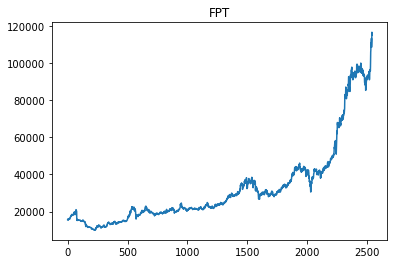

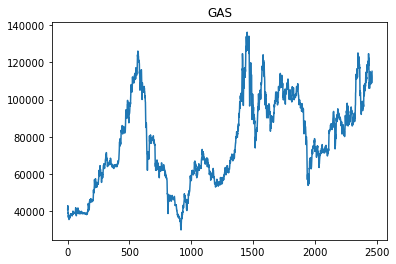

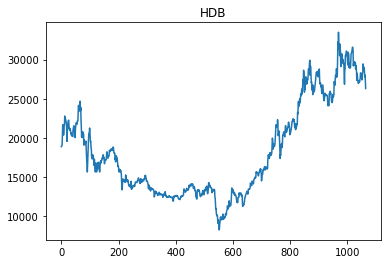

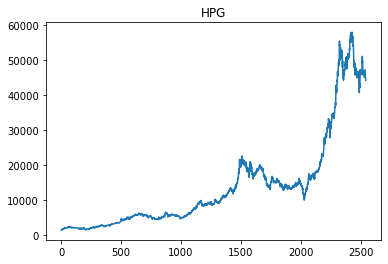

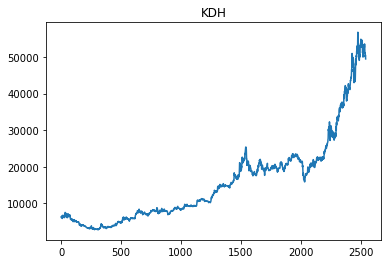

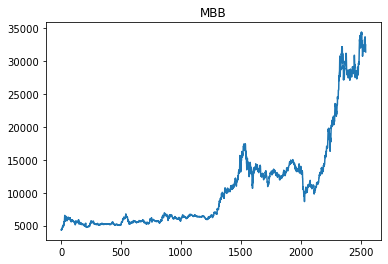

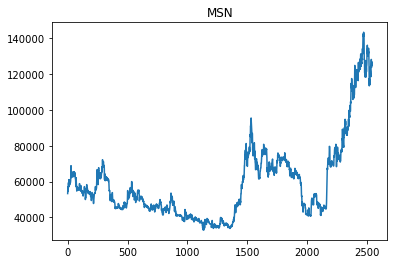

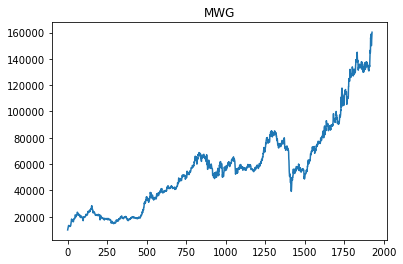

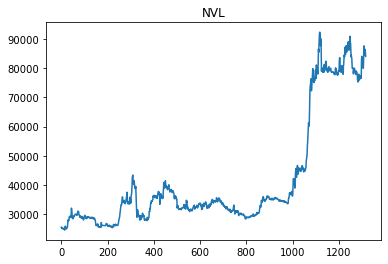

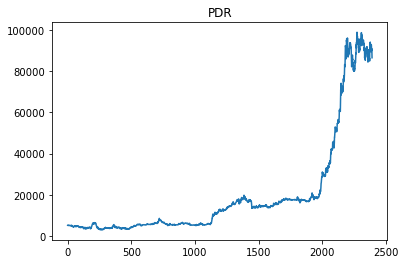

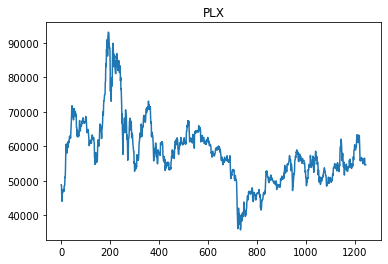

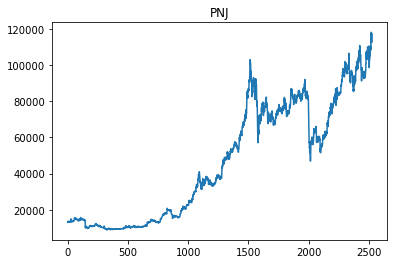

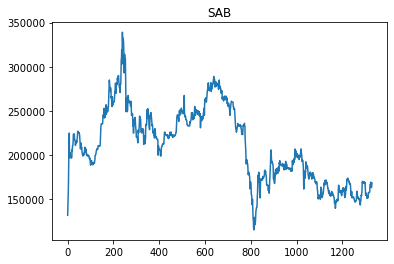

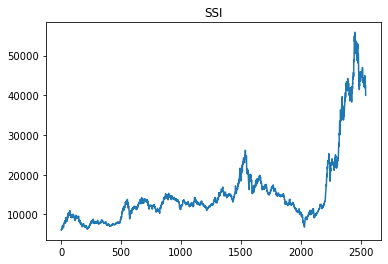

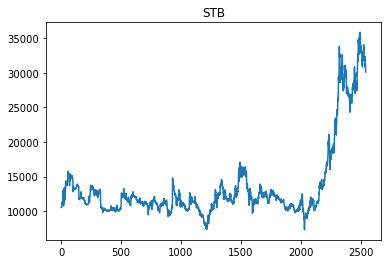

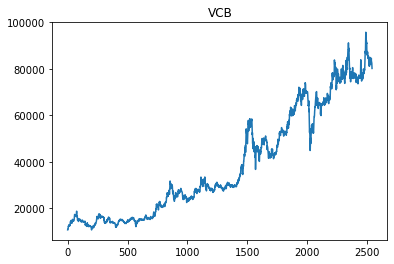

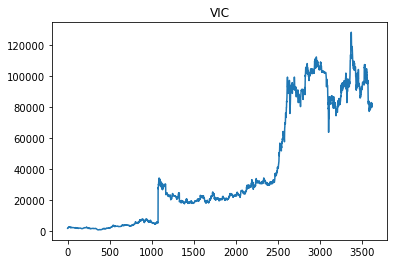

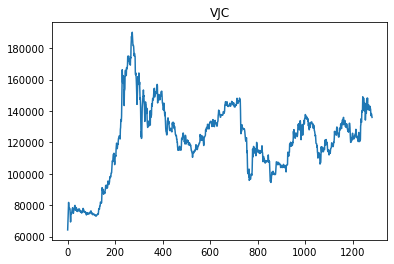

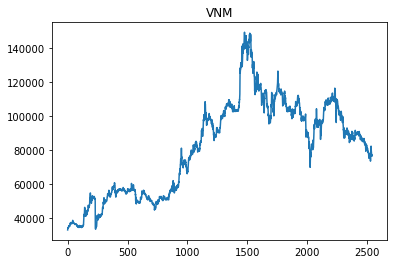

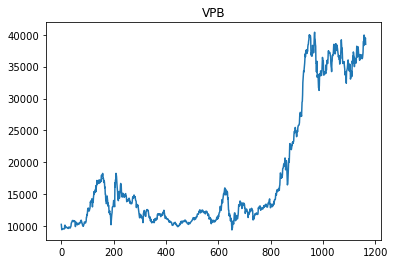

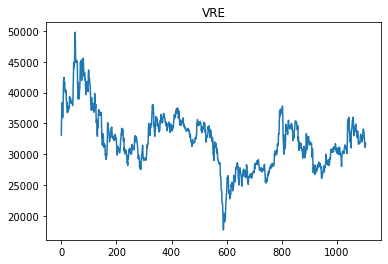

<Figure size 432x288 with 0 Axes>

In [5]:
teacher_path = '../stock_data/data_for_teacher'

source = {}
for corp in os.listdir(teacher_path):
    df = pd.read_csv(teacher_path + "/" + corp)
    
    plt.plot(df.close)
    plt.title(corp[:-4])
    plt.show()
    plt.clf()
    
    data = df.close.to_numpy().reshape(-1,1)
    
    source[corp[:-4]] = scale(data)

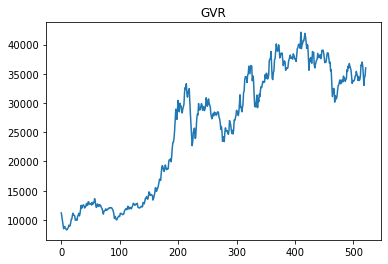

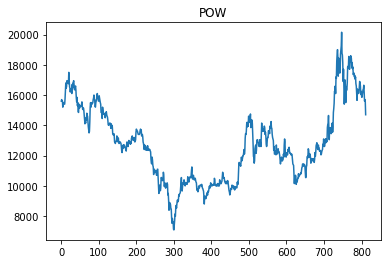

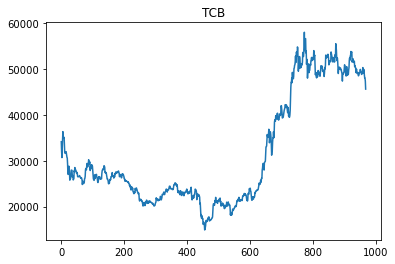

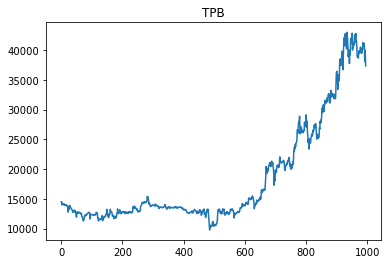

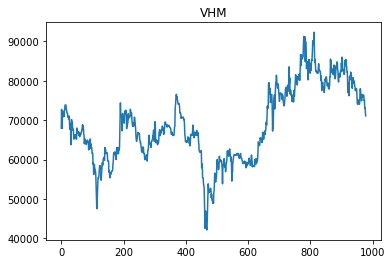

<Figure size 432x288 with 0 Axes>

In [6]:
student_path = '../stock_data/data_for_student'

target = {}
for corp in os.listdir(student_path):
    df = pd.read_csv(student_path + "/" + corp)
    
    plt.plot(df.close)
    plt.title(corp[:-4])
    plt.show()
    plt.clf()

    target[corp[:-4]] = df.close.to_numpy().reshape(-1,1)

In [7]:
src_corps = [x[:-4] for x in os.listdir(teacher_path)]
tgt_corps = [x[:-4] for x in os.listdir(student_path)]

### Data preprocessing

In [8]:
def sliding_window(dataset, l, p, scaler, device):
    x, y = [], []

    for i in range(len(dataset)-l-p+1):
        #Get input of size l, starting from index i
        _x = dataset[i: i+l, :]
        _x = scaler.transform(_x)

        #Get the next p values as label
        _y = dataset[i+l: i+l+p, 0].reshape(-1,1)
        _y = scaler.transform(_y)

        x.append(_x)
        y.append(_y)

    x = np.array(x)
    y = np.array(y)
    
    x = torch.tensor(x).to(dtype=torch.float32).to(device)
    y = torch.tensor(y).to(dtype=torch.float32).to(device)

    return (x, y)

In [9]:
def reverse_normalize(x, scaler):
    x = x.reshape(-1,1).to('cpu')
    x = scaler.inverse_transform(x)
    
    x = torch.tensor(x).to(dtype=torch.float32)
    return x

# Model pool

In [10]:
class MLP(nn.Module):

    def __init__(self, l=22, p=1):
        super(MLP, self).__init__()
        
        self.l = l
        self.p = p

        self.l1 = nn.Linear(l, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, 16)
        
        self.output = nn.Linear(16, p)
        

    def forward(self, x):
        batch_size = x.size(0)
        x = x.reshape(-1, self.l)
        
        x = self.l1(x)
        x = F.relu(x)
        
        x = self.l2(x)
        x = F.relu(x)
        
        x = self.l3(x)
        x = F.relu(x)
        
        x = self.output(x)

        return x.reshape(batch_size, -1, self.p)

In [11]:
class LSTM(nn.Module):

    def __init__(self, l=22, p=1):
        super(LSTM, self).__init__()
        
        self.l = l
        self.p = p

        self.l1 = nn.LSTM(l, 128, batch_first=True)
        self.l2 = nn.LSTM(128, 64, batch_first=True)
        self.l3 = nn.Linear(64, 16)
        self.output = nn.Linear(16, p)
        

    def forward(self, x):
        batch_size = x.size(0)
        x = x.reshape(batch_size, -1, self.l)
        
        x, _ = self.l1(x)
        x, _ = self.l2(x)
        
        x = self.l3(x)
        x = F.relu(x)
        
        x = self.output(x[:,-1,:])

        return x.reshape(batch_size, -1, self.p)

In [12]:
def build_model(MODEL, saved_path, out=True):
    net = MODEL(l, p)

    if torch.cuda.is_available():
        net.cuda()
        
    net.load_state_dict(torch.load(saved_path))
    for param in net.parameters():
        param.requires_grad = False

    if out:
        print(net)
    
    return net

# Ensemble

## Distance functions

### CORrection ALignment

In [13]:
def coral_val(data):
    n = data.shape[0]

    sum_col = np.sum(data)
    mean_col = sum_col / n

    mean_2 = mean_col**2
    data_2 = np.sum(data**2)
    
    coral_result = (data_2 - mean_2)/(n-1)
    
    return coral_result

In [14]:
def CORAL(src,tgt):
    d = src.shape[1]
    
    src_c = coral_val(src)
    tgt_c = coral_val(tgt)

    loss = (src_c-tgt_c)**2
    loss = loss/(4*d**2)
    
    return loss

### Wasserstein Distance

In [15]:
def WD(src, tgt):
    return wasserstein_distance(src.flatten(), tgt.flatten())

## Weighting method

In [16]:
base = 0.8

In [17]:
def weight(dist, total):
    return base**dist/total

In [18]:
def calculate_weights(group, src, tgt, dist, out=True):
    distances = []
    
    if out:
        print("Calculating distance")
        
    for corp in group:
        if out:
            print(corp)
    
        data = src[corp]
        d = dist(data, tgt)

        distances.append(d)
        
        if out:
            print(d)
    
    if out:
        print("Calculating weight")
    
    weights = []
    #total = np.sum(np.exp([-x for x in distances]))
    total = np.sum([base**x for x in distances])
    
    for d in distances:
        w = weight(d,total)

        if out:
            print(w)
            
        weights.append(w)
        
    return weights

## WAETL

In [19]:
class WAETL:
    def __init__(self, models, weights, p):
        self.models = models
        self.weights = weights
        self.l = p
        self.pool_size = len(models)
        
    def predict(self, x):
        result = torch.zeros((x.size(0),1,self.l)).to(device)
    
        for i in range(self.pool_size):
            pred = self.models[i](x)
            #print(pred.size())
            result += self.weights[i] * pred.detach()
            #print(result.size())
        
        return result

In [20]:
# Indicator function
def MAPE(x, y):
    return torch.mean(torch.abs((y - x) / y)) 

def RMSE(x, y):
    criterion = nn.MSELoss()
    return torch.sqrt(criterion(x, y))

def R2(x, y):
    target_mean = torch.mean(y)
    ss_tot = torch.sum((y - target_mean) ** 2)
    ss_res = torch.sum((y - x) ** 2)
    
    r2 = 1 - ss_res / ss_tot
    
    return r2

def indicator(x, y, scaler):
    x = reverse_normalize(x, scaler)
    y = reverse_normalize(y, scaler)
    
    mape = MAPE(x, y).item()
    rmse = RMSE(x, y).item()
    r2 = R2(x, y).item()
    
    return {'MAPE': mape, 'RMSE': rmse, 'R2': r2}

In [21]:
l = 22
p = 1

In [22]:
# Load the whole target for test
tgt_set = {}
scaled_target = {}

for corp, df in target.items():
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler.fit(df)

    X, Y = sliding_window(df, l, p, scaler, device)
    
    tgt_set[corp] = (X, Y, scaler)
    scaled_target[corp] = scaler.transform(df)

In [23]:
# Load finetuned models
MLP_pool = {}
LSTM_pool = {}

for tgt_corp in tgt_corps:
    print("Building pool for", tgt_corp)
    
    mlp = []
    lstm = []

    for src_corp in src_corps:
        print(src_corp)
        mlp_net = build_model(MLP, f"Models/Fine-tuned/{src_corp}_{tgt_corp}_MLP_tuned.pth", out=False)
        mlp.append(mlp_net)

        lstm_net = build_model(LSTM, f"Models/Fine-tuned/{src_corp}_{tgt_corp}_LSTM_tuned.pth", out=False)
        lstm.append(lstm_net)
        
    MLP_pool[tgt_corp] = mlp
    LSTM_pool[tgt_corp] = lstm

Building pool for GVR
ACB
BID
BVH
CTG
FPT
GAS
HDB
HPG
KDH
MBB
MSN
MWG
NVL
PDR
PLX
PNJ
SAB
SSI
STB
VCB
VIC
VJC
VNM
VPB
VRE
Building pool for POW
ACB
BID
BVH
CTG
FPT
GAS
HDB
HPG
KDH
MBB
MSN
MWG
NVL
PDR
PLX
PNJ
SAB
SSI
STB
VCB
VIC
VJC
VNM
VPB
VRE
Building pool for TCB
ACB
BID
BVH
CTG
FPT
GAS
HDB
HPG
KDH
MBB
MSN
MWG
NVL
PDR
PLX
PNJ
SAB
SSI
STB
VCB
VIC
VJC
VNM
VPB
VRE
Building pool for TPB
ACB
BID
BVH
CTG
FPT
GAS
HDB
HPG
KDH
MBB
MSN
MWG
NVL
PDR
PLX
PNJ
SAB
SSI
STB
VCB
VIC
VJC
VNM
VPB
VRE
Building pool for VHM
ACB
BID
BVH
CTG
FPT
GAS
HDB
HPG
KDH
MBB
MSN
MWG
NVL
PDR
PLX
PNJ
SAB
SSI
STB
VCB
VIC
VJC
VNM
VPB
VRE


In [24]:
coral_weights = {k:calculate_weights(src_corps, source, v, CORAL, out=False) for k, v in scaled_target.items()}
pd.DataFrame(coral_weights, index=src_corps)

,GVR,POW,TCB,TPB,VHM
ACB,0.040026,0.039909,0.040013,0.040089,0.039901
BID,0.040052,0.040111,0.040058,0.040019,0.040115
BVH,0.039992,0.040171,0.040011,0.039895,0.040184
CTG,0.040045,0.039974,0.040038,0.040084,0.039968
FPT,0.040029,0.039918,0.040017,0.040089,0.039910
GAS,0.039991,0.040171,0.040010,0.039894,0.040184
HDB,0.040025,0.040153,0.040039,0.039956,0.040162
HPG,0.040006,0.039856,0.039990,0.040087,0.039845
KDH,0.040047,0.039979,0.040040,0.040083,0.039974
MBB,0.040004,0.039852,0.039988,0.040086,0.039841


In [25]:
wd_weights = {k:calculate_weights(src_corps, source, v, WD, out=False) for k, v in scaled_target.items()}
pd.DataFrame(wd_weights, index=src_corps)

,GVR,POW,TCB,TPB,VHM
ACB,0.038932,0.038843,0.039518,0.040891,0.038575
BID,0.041042,0.040975,0.040801,0.039906,0.040666
BVH,0.040958,0.041678,0.040692,0.039479,0.041443
CTG,0.038990,0.038961,0.039576,0.040966,0.038633
FPT,0.038707,0.038679,0.039291,0.040889,0.038352
GAS,0.041835,0.041888,0.040519,0.038486,0.042487
HDB,0.041298,0.041500,0.041400,0.039374,0.041611
HPG,0.038811,0.038636,0.039379,0.040895,0.038444
KDH,0.039160,0.039082,0.039741,0.040769,0.038790
MBB,0.038776,0.038619,0.039345,0.040814,0.038407


### Predict based on CORAL distance

In [26]:
mlp_coral = {}
for corp, pack in tgt_set.items():
    print(corp)
    X, Y, scaler = pack
    
    tl_mlp_coral = WAETL(MLP_pool[corp], coral_weights[corp], p)
    pred = tl_mlp_coral.predict(X)
    
    ind = indicator(pred, Y, scaler)
    print(ind)
    
    mlp_coral[corp] = ind

GVR
{'MAPE': 0.03125987574458122, 'RMSE': 1129.8563232421875, 'R2': 0.9876857399940491}
POW
{'MAPE': 0.0184948667883873, 'RMSE': 334.4696044921875, 'R2': 0.9815713763237}
TCB
{'MAPE': 0.030638542026281357, 'RMSE': 2015.020263671875, 'R2': 0.9727964401245117}
TPB
{'MAPE': 0.04929503798484802, 'RMSE': 945.55224609375, 'R2': 0.9887887835502625}
VHM
{'MAPE': 0.016506696119904518, 'RMSE': 1498.024169921875, 'R2': 0.9754994511604309}


In [27]:
lstm_coral = {}
for corp, pack in tgt_set.items():
    print(corp)
    X, Y, scaler = pack
    
    tl_lstm_coral = WAETL(LSTM_pool[corp], coral_weights[corp], p)
    pred = tl_lstm_coral.predict(X)
    
    ind = indicator(pred, Y, scaler)
    print(ind)
    
    lstm_coral[corp] = ind

GVR
{'MAPE': 0.030059587210416794, 'RMSE': 1091.7440185546875, 'R2': 0.9885025024414062}
POW
{'MAPE': 0.018589181825518608, 'RMSE': 337.6587219238281, 'R2': 0.9812182784080505}
TCB
{'MAPE': 0.03713585063815117, 'RMSE': 2588.4990234375, 'R2': 0.955108642578125}
TPB
{'MAPE': 0.05221301689743996, 'RMSE': 1006.8358764648438, 'R2': 0.9872884154319763}
VHM
{'MAPE': 0.018223632127046585, 'RMSE': 1607.4329833984375, 'R2': 0.9717899560928345}


### Predict based on Wasserstein distance

In [28]:
mlp_wd = {}
for corp, pack in tgt_set.items():
    print(corp)
    X, Y, scaler = pack
    
    tl_mlp_wd = WAETL(MLP_pool[corp], wd_weights[corp], p)
    pred = tl_mlp_wd.predict(X)
    
    ind = indicator(pred, Y, scaler)
    print(ind)
    
    mlp_wd[corp] = ind

GVR
{'MAPE': 0.031258724629879, 'RMSE': 1129.818359375, 'R2': 0.9876865744590759}
POW
{'MAPE': 0.01848555915057659, 'RMSE': 334.36138916015625, 'R2': 0.981583297252655}
TCB
{'MAPE': 0.030610518530011177, 'RMSE': 2011.7677001953125, 'R2': 0.9728842377662659}
TPB
{'MAPE': 0.0490683875977993, 'RMSE': 943.5506591796875, 'R2': 0.9888362288475037}
VHM
{'MAPE': 0.016483595594763756, 'RMSE': 1496.0166015625, 'R2': 0.9755650758743286}


In [29]:
lstm_wd = {}
for corp, pack in tgt_set.items():
    print(corp)
    X, Y, scaler = pack
    
    tl_lstm_wd = WAETL(LSTM_pool[corp], wd_weights[corp], p)
    pred = tl_lstm_wd.predict(X)
    
    ind = indicator(pred, Y, scaler)
    print(ind)
    
    lstm_wd[corp] = ind

GVR
{'MAPE': 0.030045799911022186, 'RMSE': 1091.2362060546875, 'R2': 0.988513171672821}
POW
{'MAPE': 0.018573492765426636, 'RMSE': 337.4067687988281, 'R2': 0.981246292591095}
TCB
{'MAPE': 0.037161774933338165, 'RMSE': 2591.754638671875, 'R2': 0.9549956917762756}
TPB
{'MAPE': 0.05204175412654877, 'RMSE': 1005.2710571289062, 'R2': 0.9873279333114624}
VHM
{'MAPE': 0.018163392320275307, 'RMSE': 1603.069580078125, 'R2': 0.9719429016113281}


In [30]:
mlp_coral_results = pd.DataFrame.from_dict(mlp_coral, orient='index')
mlp_coral_results.to_csv(f"Results/mlp_coral.csv")

mlp_coral_results

,MAPE,RMSE,R2
GVR,0.031260,1129.856323,0.987686
POW,0.018495,334.469604,0.981571
TCB,0.030639,2015.020264,0.972796
TPB,0.049295,945.552246,0.988789
VHM,0.016507,1498.024170,0.975499


In [31]:
lstm_coral_results = pd.DataFrame.from_dict(lstm_coral, orient='index')
lstm_coral_results.to_csv(f"Results/lstm_coral.csv")

lstm_coral_results

,MAPE,RMSE,R2
GVR,0.030060,1091.744019,0.988503
POW,0.018589,337.658722,0.981218
TCB,0.037136,2588.499023,0.955109
TPB,0.052213,1006.835876,0.987288
VHM,0.018224,1607.432983,0.971790


In [32]:
mlp_wd_results = pd.DataFrame.from_dict(mlp_wd, orient='index')
mlp_wd_results.to_csv(f"Results/mlp_wd.csv")

mlp_wd_results

,MAPE,RMSE,R2
GVR,0.031259,1129.818359,0.987687
POW,0.018486,334.361389,0.981583
TCB,0.030611,2011.767700,0.972884
TPB,0.049068,943.550659,0.988836
VHM,0.016484,1496.016602,0.975565


In [33]:
lstm_wd_results = pd.DataFrame.from_dict(lstm_wd, orient='index')
lstm_wd_results.to_csv(f"Results/lstm_wd.csv")

lstm_wd_results

,MAPE,RMSE,R2
GVR,0.030046,1091.236206,0.988513
POW,0.018573,337.406769,0.981246
TCB,0.037162,2591.754639,0.954996
TPB,0.052042,1005.271057,0.987328
VHM,0.018163,1603.069580,0.971943
